<a href="https://colab.research.google.com/github/Keshabh/Machine-Learning/blob/main/ML11_BigMartSalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brijbhushannanda1979/bigmart-sales-data")

print("Path to dataset files:", path)

100%|██████████| 307k/307k [00:00<00:00, 68.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/brijbhushannanda1979/bigmart-sales-data/versions/1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/brijbhushannanda1979/bigmart-sales-data/versions/1/Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [ ]:
df.shape

(8523, 12)

In [ ]:
#lets fill item_weight with mean value
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
df.isnull().sum()

/tmp/ipython-input-69-13705404.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)


,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [ ]:
df.Outlet_Size.value_counts()

,count
Outlet_Size,
Medium,2793
Small,2388
High,932


In [ ]:
#outlet size matters most on the outlet type
df.Outlet_Type.value_counts()

,count
Outlet_Type,
Supermarket Type1,5577
Grocery Store,1083
Supermarket Type3,935
Supermarket Type2,928


In [ ]:
df[['Outlet_Type', 'Outlet_Size']]

,Outlet_Type,Outlet_Size
0,Supermarket Type1,Medium
1,Supermarket Type2,Medium
2,Supermarket Type1,Medium
3,Grocery Store,NaN
4,Supermarket Type1,High
...,...,...
8518,Supermarket Type1,High
8519,Supermarket Type1,NaN
8520,Supermarket Type1,Small
8521,Supermarket Type2,Medium


In [ ]:
df[['Outlet_Type', 'Outlet_Size']].groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode()[0])

,Outlet_Size
Outlet_Type,
Grocery Store,Small
Supermarket Type1,Small
Supermarket Type2,Medium
Supermarket Type3,Medium


In [ ]:
#lets use the pivot table as well, where we can do the same thing without using groupBy
df[['Outlet_Type', 'Outlet_Size']]

,Outlet_Type,Outlet_Size
0,Supermarket Type1,Medium
1,Supermarket Type2,Medium
2,Supermarket Type1,Medium
3,Grocery Store,NaN
4,Supermarket Type1,High
...,...,...
8518,Supermarket Type1,High
8519,Supermarket Type1,NaN
8520,Supermarket Type1,Small
8521,Supermarket Type2,Medium


In [ ]:
#here, we can make the values of OutletType has columns, and put the values from Outlet_Size
pv = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [ ]:
indx = df['Outlet_Size'].isnull()

In [ ]:
pv['Grocery Store']

,Grocery Store
Outlet_Size,Small


In [ ]:
# Fill missing Outlet_Size values based on the mode from the pivot table
df.loc[indx, 'Outlet_Size'] = df.loc[indx,'Outlet_Type'].apply(lambda x:pv[x])

In [ ]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


In [ ]:
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Small,4798
Medium,2793
High,932


/tmp/ipython-input-44-2420852850.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Weight'])


<Axes: xlabel='Item_Weight', ylabel='Density'>

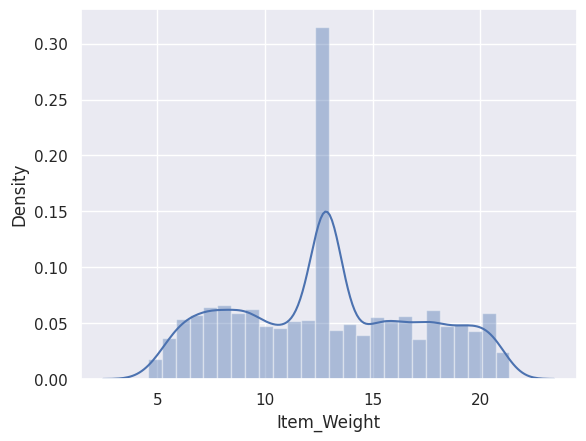

In [ ]:
import seaborn as sns
sns.set()
sns.distplot(df['Item_Weight'])

/tmp/ipython-input-45-852521860.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_Visibility'])


<Axes: xlabel='Item_Visibility', ylabel='Density'>

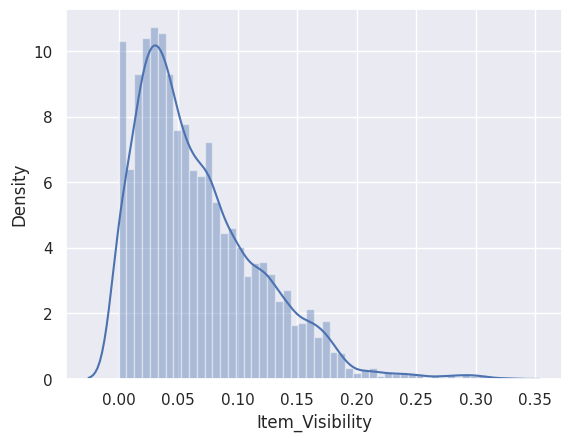

In [ ]:
sns.distplot(df['Item_Visibility'])

/tmp/ipython-input-46-3329567677.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Item_MRP'])


<Axes: xlabel='Item_MRP', ylabel='Density'>

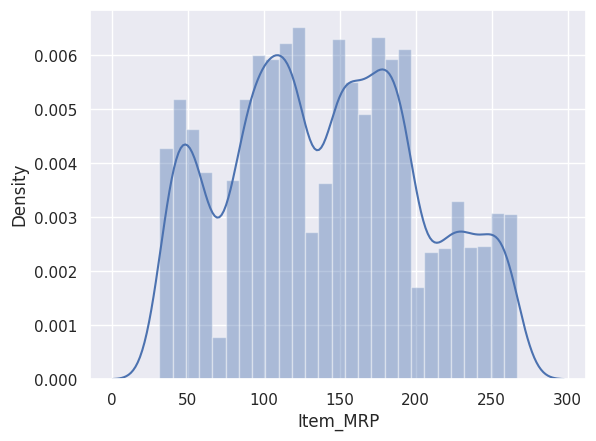

In [ ]:
sns.distplot(df['Item_MRP'])

In [ ]:
df['Outlet_Establishment_Year'].value_counts()

,count
Outlet_Establishment_Year,
1985,1463
1987,932
1999,930
1997,930
2004,930
2002,929
2009,928
2007,926
1998,555


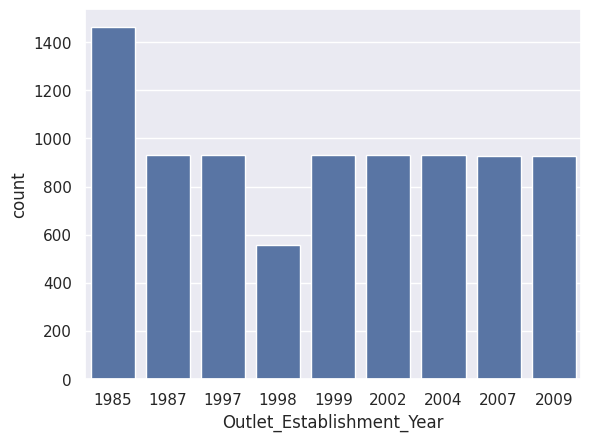

In [ ]:
sns.set()
sns.countplot(x=df['Outlet_Establishment_Year'], data=df)
plt.show()

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Outlet_Type Grocery Store Supermarket Type1 Su...,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df['Outlet_Identifier'].value_counts()

,count
Outlet_Identifier,
OUT027,935
OUT013,932
OUT035,930
OUT049,930
OUT046,930
OUT045,929
OUT018,928
OUT017,926
OUT010,555


In [ ]:
df['Item_Fat_Content'].value_counts()
df.replace({'Item_Fat_Content':{'Low Fat':0, 'LF':0, 'low fat':0,'Regular': 1, 'reg':1, 'LF':2}}, inplace=True)

/tmp/ipython-input-85-2683105702.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Item_Fat_Content':{'Low Fat':0, 'LF':0, 'low fat':0,'Regular': 1, 'reg':1, 'LF':2}}, inplace=True)


In [ ]:
#lets perform label encoding in the following:
# Item_Type
# Outlet_Type
# Outlet_Location_Type
# Outlet_Size
# Outlet_Identifier

In [ ]:
#lets perform label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Item_Type'] = le.fit_transform(df['Item_Type'])
df['Outlet_Type'] = le.fit_transform(df['Outlet_Type'])
df['Outlet_Location_Type'] = le.fit_transform(df['Outlet_Location_Type'])
df['Outlet_Size'] = le.fit_transform(df['Outlet_Size'])
df['Outlet_Identifier'] = le.fit_transform(df['Outlet_Identifier'])

In [ ]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
0,5201
1,3006
2,316


In [ ]:
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Medium,2793
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3 Outlet_Size Small Small Medium Medium,2410
Small,2388
High,932


In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,DRC01,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,FDN15,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,FDX07,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,NCD19,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [ ]:
x = df.drop(columns=['Item_Outlet_Sales','Item_Identifier'], axis=1)
y = df['Item_Outlet_Sales']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2}")

# Make predictions on the test set
predictions = model.predict(X_test)
display(predictions)

R-squared score: 0.5258988160373357


array([ 863.0986 ,  922.606  ,  926.78986, ...,  877.8092 ,  530.52045,
       1440.0586 ], dtype=float32)